Download data and Import Libraries

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shap
from sklearn.utils import resample

In [37]:
transformation_names = [
    #"Original",            # No transformation
    # "PowerTransformer",    # Uses PowerTransformer (Yeo-Johnson)
    # "Log1p",               # log(x+1) transformation
    # "Sqrt",                # Square root transformation
    "BoxCox"#,              # Box-Cox transformation (with shifting if necessary)
    # "QuantileTransformer", # Maps data to a normal distribution
    # "Normalization" 
]

In [38]:
# Directory containing the CSV files
directory = './split_data'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        df_name = filename.split('.')[0]  # Use the filename (without extension) as the key
        dataframes[df_name] = pd.read_csv(os.path.join(directory, filename))

# Display the keys of the dictionary to confirm
print(dataframes.keys())

dict_keys(['X_test_Sqrt', 'y_train', 'y_test', 'X_train_Normalization', 'data', 'X_test_Normalization', 'X_test_BoxCox', 'X_train_Original', 'X_test_PowerTransformer', 'X_train_Log1p', 'X_test_Original', 'X_train_Sqrt', 'X_train_BoxCox', 'X_train_PowerTransformer', 'X_test_Log1p', 'X_test_QuantileTransformer', 'X_train_QuantileTransformer'])


BoxCox


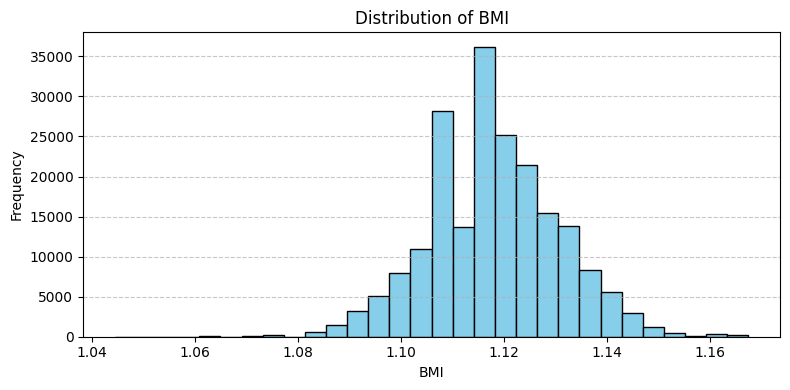

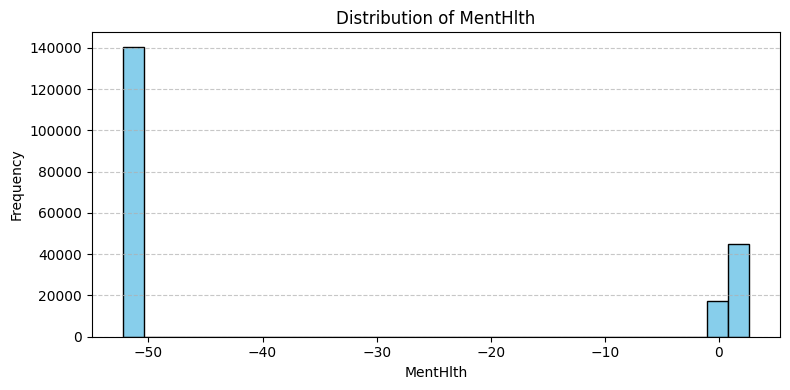

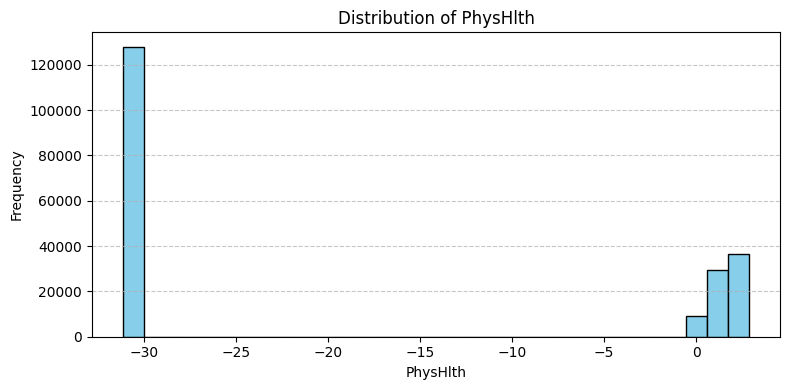

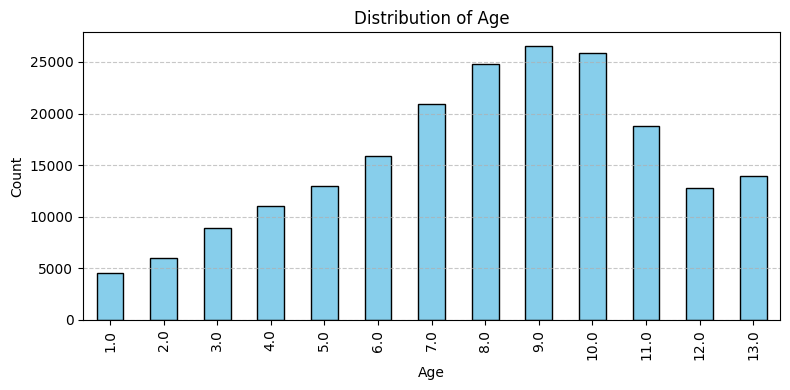

In [39]:
# Import necessary libraries
import matplotlib.pyplot as plt

features_to_visualize = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

for _ in transformation_names:

    print(_)
    name = 'X_train_' + _
    X = dataframes[name]

    # Iterate through each column in X
    for col in features_to_visualize:
        plt.figure(figsize=(8, 4))
        if X[col].nunique() < 20:  # For categorical or low-cardinality features
            X[col].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
        else:  # For continuous features
            X[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show() 

In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


continuous_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
categorical_cols = [col for col in dataframes['X_train_BoxCox'].columns if col not in continuous_cols]

# Custom implementation of Naive Bayes
# Use Gaussian distribution to predict continuous variables
# Use categorical distribution to predict discrete variables
# Combine probabilities for final prediction
class MixedNaiveBayes:
    def __init__(self, continuous_cols, categorical_cols, priors=None):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.priors = priors
        if self.priors is not None:  # If class prior is provided
            self.gaussian_nb = GaussianNB(priors=self.priors)
            self.categorical_nb = CategoricalNB(fit_prior=False, class_prior=self.priors)
        else:
            self.gaussian_nb = GaussianNB()
            self.categorical_nb = CategoricalNB()
        self.has_categorical = len(categorical_cols) > 0

    def fit(self, X, y):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Fit GaussianNB for continuous data
        self.gaussian_nb.fit(X_continuous, y)
        
        if self.has_categorical:
            # Fit CategoricalNB for categorical data
            self.categorical_nb.fit(X_categorical, y)

    def predict(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict log probabilities for continuous and categorical data
        log_prob_continuous = self.gaussian_nb.predict_log_proba(X_continuous)
        log_prob_categorical = np.zeros_like(log_prob_continuous)
        if self.has_categorical:
            log_prob_categorical = self.categorical_nb.predict_log_proba(X_categorical)
        
        # Combine log probabilities and predict the class with maximum sum
        combined_log_prob = log_prob_continuous + log_prob_categorical
        return combined_log_prob.argmax(axis=1)

    def predict_proba(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict probabilities for continuous and categorical data
        prob_continuous = self.gaussian_nb.predict_proba(X_continuous)
        if self.has_categorical:
            prob_categorical = self.categorical_nb.predict_proba(X_categorical)
            combined_prob = prob_continuous * prob_categorical
        else:
            combined_prob = prob_continuous
        return combined_prob

# Custom implementation of LinearSVC
# Default LinearSVC does NOT support predict_proba()
# Scale the decision_function output for binary classification
class CalibratedLinearSVC(LinearSVC):
    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()
    
    def predict_proba(self, X):
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

models = {
    "LR": LogisticRegressionCV(
        scoring='f1',
        max_iter=1000
    ),
    "Tree": DecisionTreeClassifier(),
    "Forest": RandomForestClassifier(),
    "SVM": CalibratedLinearSVC(),
    "3-Layer-NeuralNetwork": MLPClassifier(
        # Achitecture proposed by Masters https://books.google.com.hk/books?hl=en&lr=&id=7Ez_Pq0sp2EC&oi=fnd&pg=PR17&ots=e32CpDOplU&sig=mhxDtt79zHuEgYGBS2CUCmPyQBw&redir_esc=y#v=onepage&q&f=false
        # from https://pmc.ncbi.nlm.nih.gov/articles/PMC5968209/
        # There is only 1 hidden layer, with sqrt(input_feature_count*output_class_count) neurons
        hidden_layer_sizes=[int((len(dataframes['X_train_Original'].columns)*2)**0.5)]
    ),
    "GradBoost": GradientBoostingClassifier(),
    "knn": KNeighborsClassifier(),
    "GauNB": GaussianNB(),
    "MixNB": MixedNaiveBayes(
        continuous_cols=continuous_cols, 
        categorical_cols=categorical_cols
    ),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "xgboost": XGBClassifier()
}

def fit_models(BALANCE_TEST_DATA=True, APPLY_SMOTE_TO_TRAIN_DATA=False, UNDERSAMPLE_TRAIN_DATA=True, STAND_FEATURES=True, transformation_name='BoxCox', epochs=1):
    
    y_train, y_test = dataframes['y_train'].squeeze(), dataframes['y_test'].squeeze()
    
    for epoch in range(epochs):
        performance_metrics = []

        # Logging
        if APPLY_SMOTE_TO_TRAIN_DATA:
            print("SMOTE train data applied.\n")
        if BALANCE_TEST_DATA:
            print("Balancing test dataset applied.\n")
        if STAND_FEATURES:
            print("Standardized features applied.\n")
        if UNDERSAMPLE_TRAIN_DATA:
            print("Undersample train data appplied.\n")

        X_train_name = 'X_train_' + transformation_name
        X_test_name = 'X_test_' + transformation_name
        X_train, X_test = dataframes[X_train_name], dataframes[X_test_name]

        if UNDERSAMPLE_TRAIN_DATA:
            # Combine X_train and y_train for resampling
            X_train['target'] = y_train
            class_0 = X_train[y_train == 0]
            class_1 = X_train[y_train == 1]

            # Undersample class 0
            class_0_undersampled = resample(class_0, 
                                            replace=False, 
                                            n_samples=len(class_1), 
                                            random_state=69)

            # Combine undersampled class 0 and class 1
            X_train = pd.concat([class_0_undersampled, class_1])
            y_train = X_train['target']       

        # Oversample minority class using SMOTE
        if APPLY_SMOTE_TO_TRAIN_DATA:
            sm = SMOTE(random_state=69)
            X_train, y_train = sm.fit_resample(X_train, y_train)          

        # Balancing test data
        if BALANCE_TEST_DATA:
            X_test['target'] = y_test
            class_0_test = X_test[y_test == 0]
            class_1_test = X_test[y_test == 1]

            # Undersample class 0 in the test data
            class_0_test_undersampled = resample(class_0_test, 
                                                replace=False, 
                                                n_samples=len(class_1_test), 
                                                random_state=69)

            # Combine undersampled class 0 and class 1 in the test data
            X_test = pd.concat([class_0_test_undersampled, class_1_test])
            y_test = X_test['target']

        # Feature standardization
        if STAND_FEATURES:
            scaler = StandardScaler()
            scaler.fit_transform(X_train)
            scaler.transform(X_test)

        X_train = X_train.drop(columns=['target'])
        X_test = X_test.drop(columns=['target'])

        # Model fitting
        for name, model in models.items():

            print(f'Fitting {name}.')

            # Use CV for choose knn k
            if name == "knn":
                knn_param_grid = {
                    'n_neighbors': [5, 50, 100]
                }
                knn_grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=knn_param_grid,
                    scoring='f1', # evaluation metric
                    cv=5,
                    n_jobs=-1
                )

                knn_grid_search.fit(X_train, y_train)
                best_k = knn_grid_search.best_params_['n_neighbors']
                model = KNeighborsClassifier(n_neighbors=best_k)
                name = 'knn_' + str(best_k)
            
            # Train and evaluate the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, -1]

            # Calculate metrics
            metrics = {
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "F1 Score": f1_score(y_test, y_pred),
                "ROC AUC": roc_auc_score(y_test, y_prob)
            }

            performance_metrics.append(metrics)

            cm = confusion_matrix(y_test, y_pred)
            print(f'Confusion Matrix for {name}:\n{cm}\n')

        performance_metrics_df = pd.DataFrame(performance_metrics)
        print(performance_metrics_df)
        print(f'Completed epoch {epoch+1}/{epochs}\n')
    
    return performance_metrics

In [42]:
# Boolean variables to control pipeline
BALANCE_TEST_DATA = True 
STAND_FEATURES = True
APPLY_SMOTE_TO_TRAIN_DATA = False
UNDERSAMPLE_TRAIN_DATA = True

# Transformation method
trans_method = 'BoxCox'

# Run evaluation number of times
epochs = 1

performance_metrics_df = fit_models(BALANCE_TEST_DATA, APPLY_SMOTE_TO_TRAIN_DATA, UNDERSAMPLE_TRAIN_DATA, STAND_FEATURES, trans_method)

Balancing test dataset applied.

Standardized features applied.

Undersample train data appplied.

Fitting LR.
Confusion Matrix for LR:
[[4118 2879]
 [ 698 6299]]

Fitting Tree.
Confusion Matrix for Tree:
[[3962 3035]
 [1852 5145]]

Fitting Forest.
Confusion Matrix for Forest:
[[4019 2978]
 [ 835 6162]]

Fitting SVM.
Confusion Matrix for SVM:
[[4203 2794]
 [ 760 6237]]

Fitting 3-Layer-NeuralNetwork.
Confusion Matrix for 3-Layer-NeuralNetwork:
[[4846 2151]
 [1471 5526]]

Fitting GradBoost.
Confusion Matrix for GradBoost:
[[4066 2931]
 [ 666 6331]]

Fitting knn.
Confusion Matrix for knn_100:
[[4537 2460]
 [1309 5688]]

Fitting GauNB.
Confusion Matrix for GauNB:
[[4557 2440]
 [1291 5706]]

Fitting MixNB.
Confusion Matrix for MixNB:
[[4603 2394]
 [1253 5744]]

Fitting LDA.
Confusion Matrix for LDA:
[[4085 2912]
 [ 695 6302]]

Fitting QDA.
Confusion Matrix for QDA:
[[3879 3118]
 [ 746 6251]]

Fitting xgboost.
Confusion Matrix for xgboost:
[[4055 2942]
 [ 838 6159]]

                    Mod

In [ ]:
performance_metrics_df

[{'Model': 'LR',
  'Accuracy': 0.7443904530513077,
  'Precision': 0.6863151013292657,
  'Recall': 0.9002429612691153,
  'F1 Score': 0.7788562596599691,
  'ROC AUC': 0.82820706618196},
 {'Model': 'Tree',
  'Accuracy': 0.6507789052451051,
  'Precision': 0.6289731051344744,
  'Recall': 0.7353151350578819,
  'F1 Score': 0.6779996046649536,
  'ROC AUC': 0.6500672647860333},
 {'Model': 'Forest',
  'Accuracy': 0.7275260826068315,
  'Precision': 0.67417943107221,
  'Recall': 0.8806631413462913,
  'F1 Score': 0.7637107269009109,
  'ROC AUC': 0.8035733642681426},
 {'Model': 'SVM',
  'Accuracy': 0.7460340145776762,
  'Precision': 0.6906211936662606,
  'Recall': 0.8913820208660854,
  'F1 Score': 0.778263039680559,
  'ROC AUC': 0.8274969882864314},
 {'Model': '3-Layer-NeuralNetwork',
  'Accuracy': 0.7411747891953695,
  'Precision': 0.7198124267291911,
  'Recall': 0.7897670430184365,
  'F1 Score': 0.7531688701103993,
  'ROC AUC': 0.8102600332460415},
 {'Model': 'GradBoost',
  'Accuracy': 0.742961269